# Recommendation System

**Task: Generate the features from the dataset and use them to recommend the books accordingly to the users.**

## Understanding the Data

The Book-Crossing dataset comprises 3 files.

•	Users
Contains the users. Note that user IDs (User-ID) have been anonymized and map to integers. Demographic data is provided (Location, Age) if available. Otherwise, these fields contain NULL-values.

•	Books
Books are identified by their respective ISBN. Invalid ISBNs have already been removed from the dataset. Moreover, some content-based information is given (Book-Title, Book-Author, Year-Of-Publication, Publisher), obtained from Amazon Web Services. Note that in case of several authors, only the first is provided. URLs linking to cover images are also given, appearing in three different flavours (Image-URL-S, Image-URL-M, Image-URL-L), i.e., small, medium, large. These URLs point to the Amazon web site.

•	Ratings
Contains the book rating information. Ratings (Book-Rating) are either explicit, expressed on a scale from 1-10 (higher values denoting higher appreciation), or implicit, expressed by 0.


#  Table of Contents


1. Dependencies and Dataset
2. Exploratory Data Analysis(EDA)
3. Data Exploration
4. Popularity-Based Recommendation
5. Collaborative Filtering Based Recommender System
6. Evaluation 
7. Deployment

# 1. Dependancies and Dataset

### Import the Libraries

In [5]:
# Importing necessary libraries for association rule mining and visualization
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import string
import re

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from scipy.sparse import csr_matrix

# change defaults
sns.set_context('notebook')
sns.set_style('darkgrid')
sns.set_palette('rainbow')

In [6]:
books = pd.read_csv("Books.csv")
ratings = pd.read_csv("Ratings.csv") 
users = pd.read_csv("Users.csv")

### Importing Datasets

In [7]:
#Columns Names
book_cols = ['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL']
rating_cols = ['userId','ISBN','bookRating']
user_cols = ['userId','location','age']

books.columns = book_cols

ratings.columns = rating_cols

users.columns = user_cols

In [8]:
# Displaying first two entries of Books data using [DataFrame.head()]
books.head(5)

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [9]:
# Displaying first Five entries of Ratings data
ratings.head(5)

,userId,ISBN,bookRating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [10]:
# Displaying first five entries of users Data
users.head(5)

,userId,location,age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


# 2. Exploratory Data Analysis(EDA)

#### Summerize Data

#### Shape

In [11]:
# Shape of the Books data set
books.shape

(271360, 8)

Books data shows the shape of the dataset i.e. there are 271360 rows and 8 columns.

In [12]:
# Shape of the Ratings data set
ratings.shape

(1149780, 3)

Ratings data shows the shape of the dataset i.e. there are 1149780 rows and 3 columns.

In [13]:
# Shape of the users data set
users.shape

(278858, 3)

users data shows the shape of the dataset i.e. there are 278858 rows and 3 columns.

#### Data types

In [14]:
# Data types of the books data set
books.dtypes

ISBN                 object
bookTitle            object
bookAuthor           object
yearOfPublication    object
publisher            object
imageUrlS            object
imageUrlM            object
imageUrlL            object
dtype: object

In [15]:
# Data types of the ratings data set
ratings.dtypes

userId         int64
ISBN          object
bookRating     int64
dtype: object

In [16]:
# Data types of the users data set
users.dtypes

userId        int64
location     object
age         float64
dtype: object

In [18]:
# Note: Used Pandas Series.str.split method as it has an 'expand' parameter which can handle None cases
user_location_expanded = users.location.str.split(',',n=2, expand=True)
user_location_expanded.columns = ['city', 'state', 'country']
users = users.join(user_location_expanded)

In [19]:
users.drop(columns=['location'], inplace=True)
users.head()

,userId,age,city,state,country
0,1,NaN,nyc,new york,usa
1,2,18.0,stockton,california,usa
2,3,NaN,moscow,yukon territory,russia
3,4,17.0,porto,v.n.gaia,portugal
4,5,NaN,farnborough,hants,united kingdom


#### Checking Information

In [20]:
# Information of books dataset
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   ISBN               271360 non-null  object
 1   bookTitle          271360 non-null  object
 2   bookAuthor         271358 non-null  object
 3   yearOfPublication  271360 non-null  object
 4   publisher          271358 non-null  object
 5   imageUrlS          271360 non-null  object
 6   imageUrlM          271360 non-null  object
 7   imageUrlL          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


In [21]:
# Information of ratings dataset
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   userId      1149780 non-null  int64 
 1   ISBN        1149780 non-null  object
 2   bookRating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [22]:
# Information of users dataset
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   278858 non-null  int64  
 1   age      168096 non-null  float64
 2   city     278858 non-null  object 
 3   state    278857 non-null  object 
 4   country  278856 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 10.6+ MB


## Clean Data

### Missing Value

In [23]:
# Check for missing values in the dataset
missing_values = books.isnull().sum()

print(missing_values)

ISBN                 0
bookTitle            0
bookAuthor           2
yearOfPublication    0
publisher            2
imageUrlS            0
imageUrlM            0
imageUrlL            3
dtype: int64


In [24]:
# Check for missing values in the dataset
missing_values = ratings.isnull().sum()

print(missing_values)

userId        0
ISBN          0
bookRating    0
dtype: int64


In [25]:
# Check for missing values in the dataset
missing_values = users.isnull().sum()

print(missing_values)

userId          0
age        110762
city            0
state           1
country         2
dtype: int64


## Checking Books Data

In [26]:
books.nunique() #  used to count the number of unique elements in each column of the DataFrame.

ISBN                 271360
bookTitle            242135
bookAuthor           102022
yearOfPublication       202
publisher             16807
imageUrlS            271044
imageUrlM            271044
imageUrlL            271041
dtype: int64

In [27]:
books.yearOfPublication.unique() # it counts of each unique element in the array.

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984, 0, 1968, 1961, 1958, 1974,
       1976, 1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960,
       1966, 1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954,
       1950, 1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011,
       1925, 1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 2030,
       1911, 1904, 1949, 1932, 1928, 1929, 1927, 1931, 1914, 2050, 1934,
       1910, 1933, 1902, 1924, 1921, 1900, 2038, 2026, 1944, 1917, 1901,
       2010, 1908, 1906, 1935, 1806, 2021, '2000', '1995', '1999', '2004',
       '2003', '1990', '1994', '1986', '1989', '2002', '1981', '1993',
       '1983', '1982', '1976', '1991', '1977', '1998', '1992', '1996',
       '0', '1997', '2001', '1974', '1968', '1987', '1984', '1988',
       '1963', '1956', '1970', '1985', '1978', '1973', '1980'

**We can observe from above that some author names are mixed up in year data like 'DK Publishing Inc' and 'Gallimard'**

**Checking the rows having 'DK Publishing Inc' as yearOfPublication using [DataFrame.loc[]](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.loc.html) method**

In [28]:
books.loc[books.yearOfPublication == 'DK Publishing Inc',:]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL
209538,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,NaN
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,NaN


**There are Two Books with wrong year entries, Hence we will correct them below**

In [29]:
books.loc[books.ISBN == '078946697X','imageUrlL'] = 'http://images.amazon.com/images/P/078946697X.01.LZZZZZZZ.jpg'
books.loc[books.ISBN == '078946697X','imageUrlM'] = 'http://images.amazon.com/images/P/078946697X.01.MZZZZZZZ.jpg'
books.loc[books.ISBN == '078946697X','imageUrlS'] = 'http://images.amazon.com/images/P/078946697X.01.THUMBZZZ.jpg'
books.loc[books.ISBN == '078946697X','publisher'] = 'DK Publishing Inc'
books.loc[books.ISBN == '078946697X','yearOfPublication'] = '2000'
books.loc[books.ISBN == '078946697X','bookAuthor'] = 'Michael Teitelbaum'
books.loc[books.ISBN == '078946697X','bookTitle'] = 'DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)'

In [30]:
books.loc[books.ISBN == '0789466953','imageUrlL'] = 'http://images.amazon.com/images/P/0789466953.01.LZZZZZZZ.jpg'
books.loc[books.ISBN == '0789466953','imageUrlM'] = 'http://images.amazon.com/images/P/0789466953.01.MZZZZZZZ.jpg'
books.loc[books.ISBN == '0789466953','imageUrlS'] = 'http://images.amazon.com/images/P/0789466953.01.THUMBZZZ.jpg'
books.loc[books.ISBN == '0789466953','publisher'] = 'DK Publishing Inc'
books.loc[books.ISBN == '0789466953','yearOfPublication'] = '2000'
books.loc[books.ISBN == '0789466953','bookAuthor'] = 'James Buckley'
books.loc[books.ISBN == '0789466953','bookTitle'] = "DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)"

In [31]:
books.loc[books.ISBN == '078946697X',:]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL
209538,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",Michael Teitelbaum,2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...


In [32]:
books.loc[books.ISBN == '0789466953',:]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",James Buckley,2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...


#### Checking the rows having 'Gallimard' as yearOfPublication

In [33]:
books.loc[books.yearOfPublication == 'Gallimard',:]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-M...",2003,Gallimard,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,NaN


This Book with wrong year entry, Hence we will correct that below,

In [34]:
books.loc[books.ISBN == '2070426769','imageUrlL'] = 'http://images.amazon.com/images/P/2070426769.01.LZZZZZZZ.jpg'
books.loc[books.ISBN == '2070426769','imageUrlM'] = 'http://images.amazon.com/images/P/2070426769.01.MZZZZZZZ.jpg'
books.loc[books.ISBN == '2070426769','imageUrlS'] = 'http://images.amazon.com/images/P/2070426769.01.THUMBZZZ.jpg'
books.loc[books.ISBN == '2070426769','publisher'] = 'Gallimard'
books.loc[books.ISBN == '2070426769','yearOfPublication'] = '2003'
books.loc[books.ISBN == '2070426769','bookAuthor'] = 'Jean-Marie Gustave Le ClÃ?Â©zio'
books.loc[books.ISBN == '2070426769','bookTitle'] = "Peuple du ciel, suivi de 'Les Bergers"

In [35]:
books.loc[books.ISBN == '2070426769',:]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers",Jean-Marie Gustave Le ClÃ?Â©zio,2003,Gallimard,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...


### Storing Image URLs in different DataFrame because we don't need them now

In [36]:
books_data = books[['ISBN', 'bookTitle','imageUrlS', 'imageUrlM', 'imageUrlL']]
books = books[['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher']]

Verifying the changes in publication year

In [37]:
books.loc[(books.ISBN == '2070426769') | (books.ISBN == '078946697X') | (books.ISBN == '0789466953'),: ]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
209538,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",Michael Teitelbaum,2000,DK Publishing Inc
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers",Jean-Marie Gustave Le ClÃ?Â©zio,2003,Gallimard
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",James Buckley,2000,DK Publishing Inc


Converting year data from object type to numeric using [pd.to_numeric](https://pandas.pydata.org/docs/reference/api/pandas.to_numeric.html) and if error occurs replacing them with NAN values

In [38]:
books.yearOfPublication = pd.to_numeric(books.yearOfPublication, errors='coerce')

The value 0 for year is invalid and as this dataset was published in 2004, I have assumed the the years after 2006 to be
invalid keeping some margin in case dataset was updated thereafer setting invalid years as NaN

In [39]:
books.loc[(books.yearOfPublication > 2006) | (books.yearOfPublication == 0),'yearOfPublication'] = np.NAN

Using [Series.fillna()](https://pandas.pydata.org/docs/reference/api/pandas.Series.fillna.html) to fill the NAN values with mean value of the years and then converting data type to int

In [40]:
books.yearOfPublication.fillna(round(books.yearOfPublication.mean()),inplace=True)
convert_dict = {'yearOfPublication': np.int64,}
books = books.astype(convert_dict)

**Checking if there are NULL values present in publisher column using [Series.isnull()](https://pandas.pydata.org/docs/reference/api/pandas.Series.isnull.html)**

In [41]:
books.loc[books.publisher.isnull(),:]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
128890,193169656X,Tyrant Moon,Elaine Corvidae,2002,NaN
129037,1931696993,Finders Keepers,Linnea Sinclair,2001,NaN


**Checking with rows having bookTitle as Tyrant Moon to see if we can get any clues**

In [42]:
books.loc[(books.bookTitle == 'Tyrant Moon'),:]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
128890,193169656X,Tyrant Moon,Elaine Corvidae,2002,NaN


**No clues for Tyrant Moon , Hence checking with rows having bookTitle as Finders Keepers to see if we can get any clues**

In [43]:
books.loc[(books.bookTitle == 'Finders Keepers'),:]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
10799,082177364X,Finders Keepers,Fern Michaels,2002,Zebra Books
42019,0070465037,Finders Keepers,Barbara Nickolae,1989,McGraw-Hill Companies
58264,0688118461,Finders Keepers,Emily Rodda,1993,Harpercollins Juvenile Books
66678,1575663236,Finders Keepers,Fern Michaels,1998,Kensington Publishing Corporation
129037,1931696993,Finders Keepers,Linnea Sinclair,2001,NaN
134309,0156309505,Finders Keepers,Will,1989,Voyager Books
173473,0973146907,Finders Keepers,Sean M. Costello,2002,Red Tower Publications
195885,0061083909,Finders Keepers,Sharon Sala,2003,HarperTorch
211874,0373261160,Finders Keepers,Elizabeth Travis,1993,Worldwide Library


**No clues here either as every book has different publishers , So checking  with rows having author Elaine Corvidae and Linnea Sinclair**

In [44]:
books.loc[(books.bookAuthor == 'Elaine Corvidae') | (books.bookAuthor == 'Linnea Sinclair'),:]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
126762,1931696934,Winter's Orphans,Elaine Corvidae,2001,Novelbooks
128890,193169656X,Tyrant Moon,Elaine Corvidae,2002,NaN
129001,0759901880,Wolfkin,Elaine Corvidae,2001,Hard Shell Word Factory
129037,1931696993,Finders Keepers,Linnea Sinclair,2001,NaN


Assinging the Null publisher values as 'Unknown'

In [45]:
books.loc[(books.ISBN == '193169656X'),'publisher'] = 'Unknown'
books.loc[(books.ISBN == '1931696993'),'publisher'] = 'Unknown'

In [46]:
books.loc[books.ISBN == '193169656X',:]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
128890,193169656X,Tyrant Moon,Elaine Corvidae,2002,Unknown


#### Checking for Null bookAuthor names

In [47]:
books.loc[books.bookAuthor.isnull(),:]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
118033,0751352497,A+ Quiz Masters:01 Earth,NaN,1999,Dorling Kindersley
187689,9627982032,The Credit Suisse Guide to Managing Your Perso...,NaN,1995,Edinburgh Financial Publishing


Lets give the Null bookAuthor value as 'Unknown'

In [48]:
books.loc[(books.ISBN == '9627982032'),'bookAuthor'] = 'Unknown'

In [49]:
books.loc[books.ISBN == '9627982032',:]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
187689,9627982032,The Credit Suisse Guide to Managing Your Perso...,Unknown,1995,Edinburgh Financial Publishing


### Checking Users Data

Checking for number of null values and data types of data provided inside columns

In [50]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   278858 non-null  int64  
 1   age      168096 non-null  float64
 2   city     278858 non-null  object 
 3   state    278857 non-null  object 
 4   country  278856 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 10.6+ MB


#### Age values below 4 and above 90 does not make much sense for our book rating case, hence replacing these by NANs

In [51]:
users.loc[(users.age > 90) | (users.age < 4), 'age'] = np.nan

Replacing NANs with mean value of users and converting data type to int

In [52]:
users['age'].value_counts()

age
24.0    5687
25.0    5618
26.0    5547
23.0    5456
27.0    5383
        ... 
86.0       7
87.0       6
90.0       5
89.0       2
88.0       2
Name: count, Length: 87, dtype: int64

In [53]:
users.age.median()

32.0

In [54]:
users.age = users.age.fillna(users.age.median())
users.age = users.age.astype(np.int64)

### Checking Ratings Data

Checking for Null values and data types of Ratings data

In [55]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   userId      1149780 non-null  int64 
 1   ISBN        1149780 non-null  object
 2   bookRating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


Looks like it doesn't have any NAN values, So let's have a look at bookRating values

In [56]:
ratings.head()

,userId,ISBN,bookRating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [57]:
ratings.nunique() # it returns the number of unique elements along a specified axis.

userId        105283
ISBN          340556
bookRating        11
dtype: int64

In [58]:
ratings.bookRating.unique() # it is used to find the unique elements of an array.

array([ 0,  5,  3,  6,  8,  7, 10,  9,  4,  1,  2], dtype=int64)

bookRatings are always under 0-10, also Ratings dataset will have n_users $\times$ n_books entries if every user rated every item,

In [59]:
n_users = users.shape[0]
n_books = books.shape[0]
print(n_users * n_books)

75670906880


A "sparse dataset" refers to a dataset in which most of the elements are zero. In other words, the majority of the values in the dataset are not populated or are explicitly marked as missing or undefined. This sparsity often occurs in large datasets where most of the potential entries have not been observed or are irrelevant to the problem at hand.

**From above we can say that the dataset is very sparse,  
Ratings dataset should have books only which exist in our books dataset, unless new books are added to books dataset**

In [60]:
ratings_new = ratings[ratings.ISBN.isin(books.ISBN)] # filter isin
ratings_new
# ratings_new contains rows from ratings where 'ISBN' values are in books.ISBN.

,userId,ISBN,bookRating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6
...,...,...,...
1149774,276704,0876044011,0
1149775,276704,1563526298,9
1149776,276706,0679447156,0
1149777,276709,0515107662,10


Also Ratings dataset should have ratings from users which exist in users dataset, unless new users are added to users dataset

In [61]:
ratings_new = ratings_new[ratings_new.userId.isin(users.userId)]
#Note: All users who rated are already inside users dataset

### Dataset [Sparsity] Calculation

In [62]:
sparsity = 1 - (len(ratings_new)/(n_users*n_books))
print("No. of users = " + str(n_users) + ", No. of Books = " + str(n_books)
      + "\nThe Following Dataset has " + str(sparsity*100) + " % Sparsity")

No. of users = 278858, No. of Books = 271360
The Following Dataset has 99.99863734155898 % Sparsity


Making two new ratings dataframes where ratings which are other than 0 are present and vice a versa

In [63]:
rating_explicit = ratings_new.loc[ratings_new.bookRating != 0, :] #  rows where the 'bookRating' column is not equal to 0.
rating_implicit = ratings_new.loc[ratings_new.bookRating == 0, :] # rows where the 'bookRating' column is equal to 0.
print("Explicit Ratings data shape = " + str(rating_explicit.shape) + "\nImplicit Ratings data shape = " + str(rating_implicit.shape))

Explicit Ratings data shape = (383842, 3)
Implicit Ratings data shape = (647294, 3)


## Visualising Explicit Rating Counts

 Included only rows where the 'bookRating' column is not equal to 0.

Using [Seaborn](https://towardsdatascience.com/seaborn-python-8563c3d0ad41) Library for ploting a [countplot](https://www.geeksforgeeks.org/countplot-using-seaborn-in-python/)

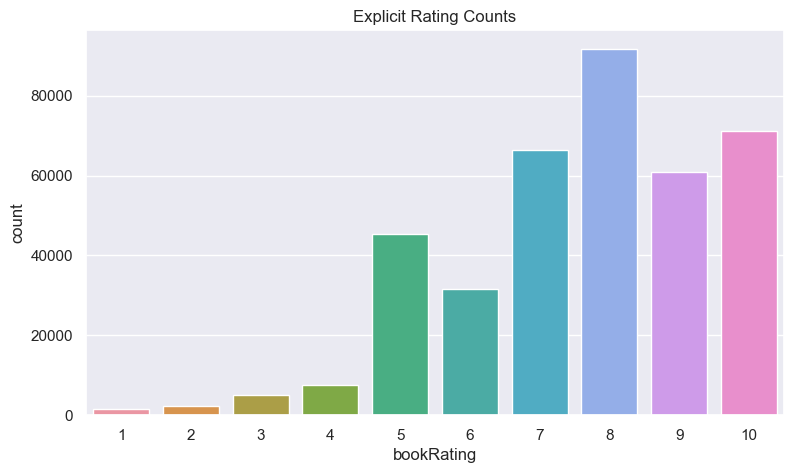

In [64]:
plt.figure(figsize=(9, 5))
plt.title('Explicit Rating Counts')
sns.countplot(x = 'bookRating', data = rating_explicit);

### Cleaning Title text

Function for cleaning title text using [Regex](https://en.wikipedia.org/wiki/Regular_expression) Library

In [65]:
def clean_text(text):
    #removal of url
    text = re.sub(r'https?://\S+|www\.\S+|http?://\S+',' ',text)

    #removal of html tags
    text = re.sub(r'<.*?>',' ',text)

    text = re.sub("["
                           u"\U0001F600-\U0001F64F"  # removal of emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+",' ',text)


    #remove newline char
    text = re.sub('\n', '', text)

    return text

Applying clean_text() function on bookTitle column

In [66]:
books.bookTitle = books.bookTitle.apply(lambda x:clean_text(x)) # apply method

Merging Books and Ratings data using [pd.merge()](https://www.geeksforgeeks.org/python-pandas-merging-joining-and-concatenating/)

In [67]:
merged_data1 = pd.merge(books, ratings_new, on='ISBN')
merged_data = pd.merge(merged_data1, users, on='userId')
merged_data =  merged_data.sort_values('ISBN', ascending=True)
merged_data.head()

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,userId,bookRating,age,city,state,country
307558,0000913154,The Way Things Work: An Illustrated Encycloped...,C. van Amerongen (translator),1967,Simon &amp; Schuster,171118,8,47,toronto,ontario,canada
454163,0001010565,Mog's Christmas,Judith Kerr,1992,Collins,209516,0,57,felixstowe,suffolk,united kingdom
256671,0001010565,Mog's Christmas,Judith Kerr,1992,Collins,86123,0,32,peterborough,ontario,canada
210337,0001046438,Liar,Stephen Fry,1994,Harpercollins Uk,23902,9,32,london,england,united kingdom
827421,0001046713,Twopence to Cross the Mersey,Helen Forrester,1992,HarperCollins Publishers,196149,0,29,lisburn,northern ireland,united kingdom


# 3. Data Exploration

### Visualising top 30 most read books

Using [Series.value_counts()](https://pandas.pydata.org/docs/reference/api/pandas.Series.value_counts.html) and [sns.barplot](https://seaborn.pydata.org/generated/seaborn.barplot.html) for creating data and visualisation respectively

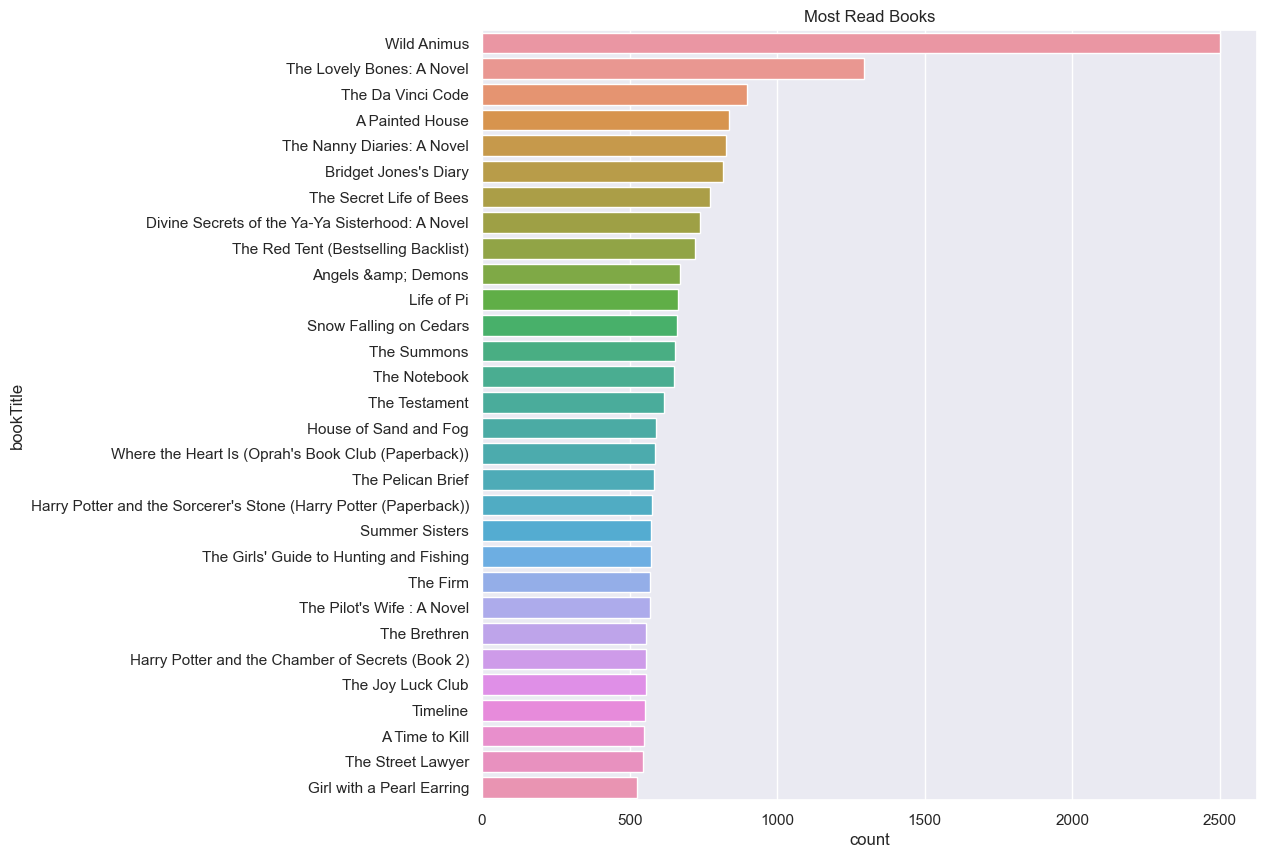

In [68]:
most_read = merged_data.bookTitle.value_counts().reset_index()
most_read.columns = ['bookTitle','count']

plt.figure(figsize = (10,10))
plt.title("Most Read Books")
sns.barplot(x = 'count', y = 'bookTitle', data = most_read.head(30));

### Top rated books(average rating according to number of users)

**We may observe many books with average rating equal to 10 and 0 as many of the books are rated only once, hence this can't show us a good visualisation.**

Performing on merged_data to find the mean ratings for each book title and then sorting the result to get the top-rated books.

In [69]:
top_rated = merged_data[['bookTitle','bookRating']]
top_rated = top_rated.groupby('bookTitle', as_index=False)['bookRating'].mean()
top_rated = top_rated.sort_values('bookRating',ascending=False).reset_index()
top_rated = top_rated[['bookTitle','bookRating']]

top_rated.head()

,bookTitle,bookRating
0,Film Is: The International Free Cinema,10.0
1,More Secrets of Happy Children: Embrace Your P...,10.0
2,Jo's Boys : From the Original Publisher,10.0
3,The Vanished Priestess : An Annie Szabo Mystery,10.0
4,Game and Hunting,10.0


In [70]:
top_rated.tail()

,bookTitle,bookRating
241066,Invaders of the Planet Earth (Choose Your Own ...,0.0
241067,Sammy Discovers the Alphabet (Learn-With-Sammy),0.0
241068,Sammy Carducci's Guide to Women,0.0
241069,Sammle mir Kiesel am FluÃ?Â?. Mehr als eine Li...,0.0
241070,TRAVELLING MAN,0.0


### Visualising top 30 most read books with there average ratings

Using [DataFrame.groupby()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html) and [DataFrame.sort_values()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html) for ploting a barplot

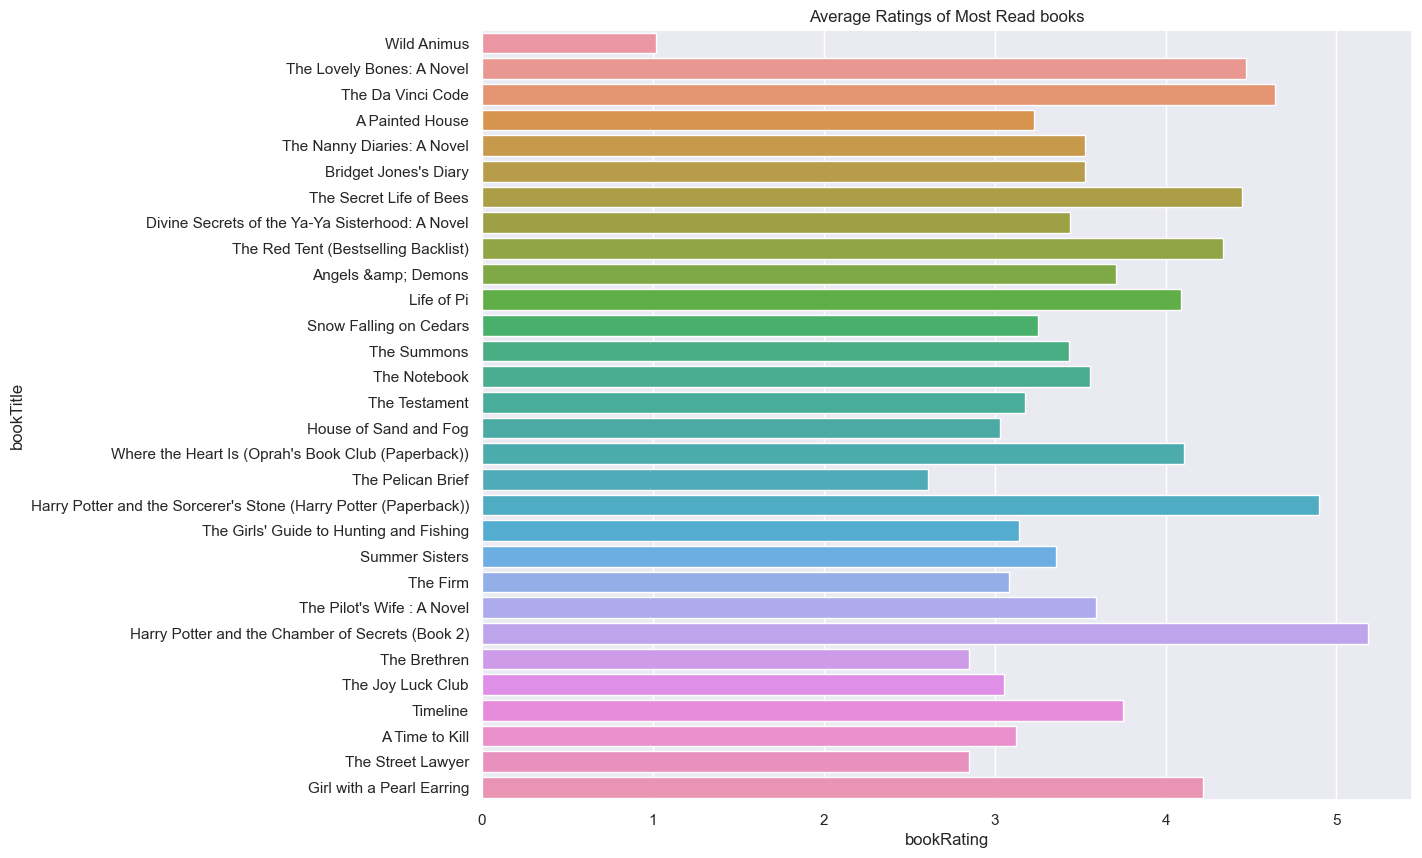

In [71]:
# Calculate Average Ratings
avg_data = merged_data.groupby('bookTitle', as_index=False)['bookRating'].mean()

# Count the Number of Reads for Each Book
temp = merged_data.bookTitle.value_counts().reset_index()
temp.columns = ['bookTitle','count']

 # Merge Average Ratings with Read Counts
most_rated_by_reads = pd.merge(avg_data,temp,on='bookTitle')
most_rated_by_reads = most_rated_by_reads.sort_values('count',ascending=False)

# Plotting the Bar Plot
plt.figure(figsize=(12,10))
plt.title("Average Ratings of Most Read books")
sns.barplot(x = 'bookRating', y = 'bookTitle', data = most_rated_by_reads.head(30));

The chart reveals the average ratings of the most-read books in the dataset. By examining the bars in the bar plot, you can identify books that are not only popular (have a high count of reads) but also receive high average ratings. This can provide insights into books that are both widely accepted by readers and highly regarded in terms of quality.

### Visualising Count of Books with a specific length

Creating title_length data for every title in bookTitle column and ploting a histplot

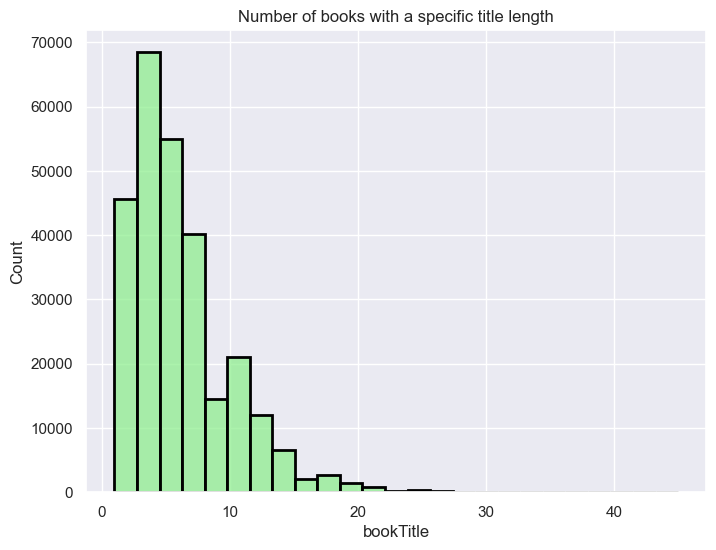

In [72]:
# Calculate Title Lengths
title_length = books.bookTitle.str.split().map(lambda x: len(x))

# Plot the Histogram:
plt.figure(figsize=(8,6))
plt.title('Number of books with a specific title length')
sns.histplot(title_length, bins=25, color = 'lightgreen', linewidth = 2, edgecolor = 'black');

Each bar in the histogram represents a range of title lengths (specified by the bins), and the height of the bar indicates the number of books with titles falling within that length range.

The chart reveals how many books in the dataset have titles of different lengths. Each bar in the histogram represents a range of title lengths (specified by the bins), and the height of the bar indicates the number of books with titles falling within that length range. By examining the chart, you can infer the most common title lengths, the spread of title lengths, and whether there are any notable patterns or outliers.`

### Visualising top 30 years with most book being published

We count the number of times a book is published in a particular year and plot a barplot

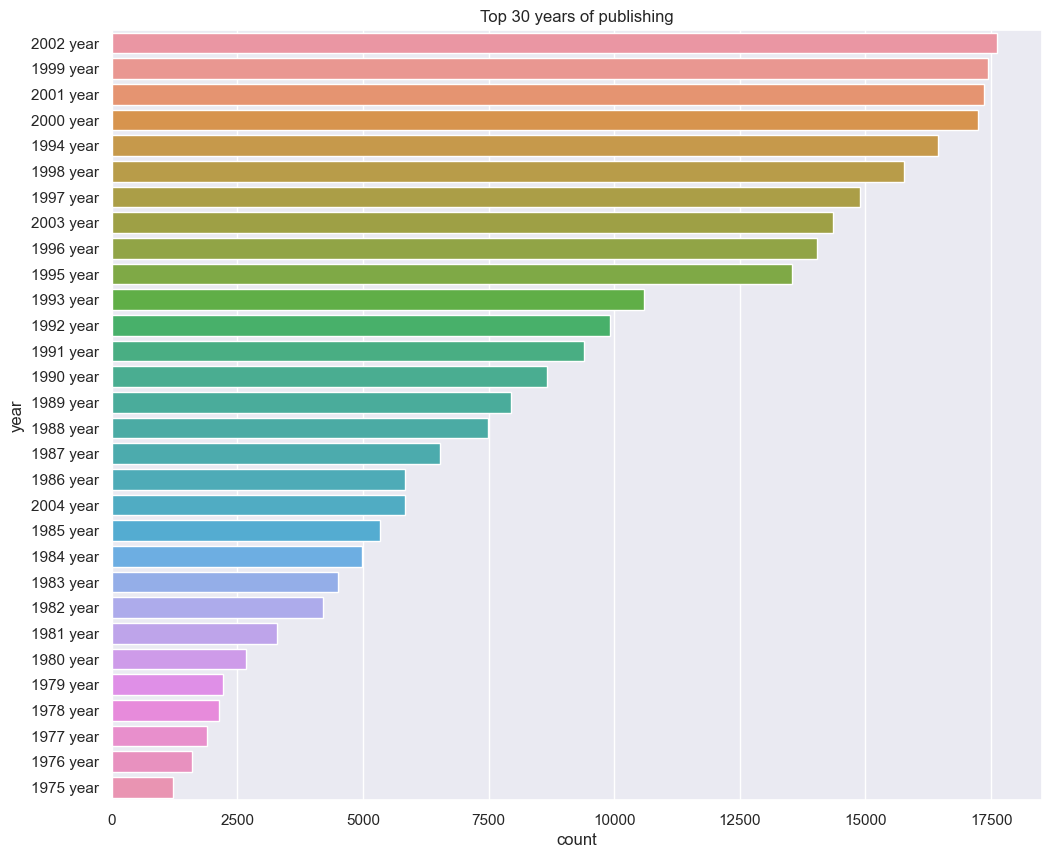

In [73]:
# Count the Number of Books for Each Publication Year
yearOP = books['yearOfPublication'].value_counts().reset_index()

# Rename Columns
yearOP.columns = ['value', 'count']

# Create a 'year' Column
yearOP['year'] = yearOP['value'].astype(str) + ' year'
yearOP = yearOP.sort_values('count',ascending=False)

# Plotting the Bar Plot
plt.figure(figsize=(12,10))
plt.title('Top 30 years of publishing')
sns.barplot(data = yearOP.head(30), x='count', y="year");

The chart tells you about the popularity or prevalence of books published in different years. By examining the bars in the bar plot, you can identify which years have a higher count of books, indicating periods of potentially higher publishing activity. Peaks or patterns in the distribution may suggest trends in the dataset, such as periods with a significant number of popular or influential books.

### Visualising top 30 authors with most books

We count the number of times a book written by an author and plot a barplot for the top 30 authors

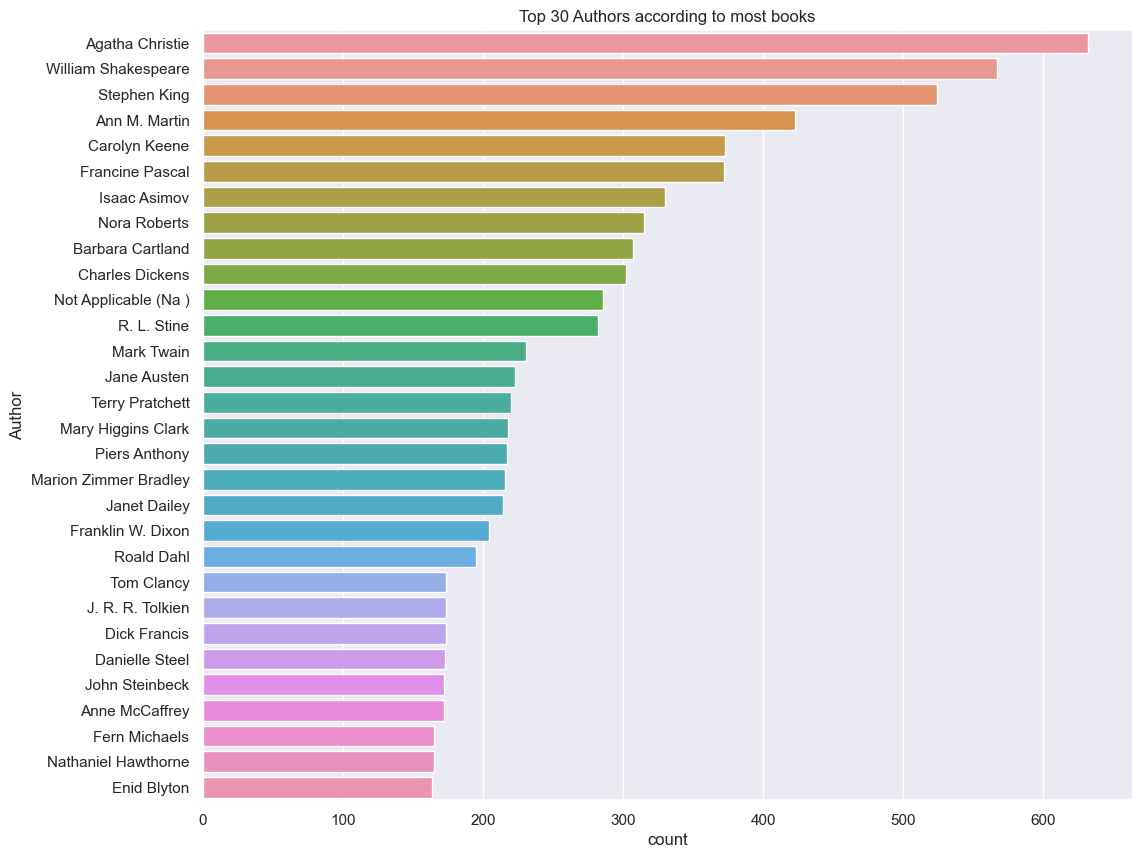

In [74]:
# Count the Number of Books for Each Author
top_author = books['bookAuthor'].value_counts().reset_index()
# Rename Columns
top_author.columns = ['Author', 'count']
top_author['Author'] = top_author['Author']
top_author = top_author.sort_values('count',ascending=False)

# Plotting the Bar Plot
plt.figure(figsize=(12,10))
plt.title('Top 30 Authors according to most books')
sns.barplot(data = top_author.head(30), x = 'count', y = 'Author');

The chart provides information on which authors have the highest counts of books in the dataset. It gives a sense of the distribution of authorship, highlighting those authors who have written the most books.

The plot provides insights into the popularity or prolificacy of authors in the dataset and can be useful for understanding which authors have the most significant presence based on the number of books they've written.

### Visualising top 30 publishers with most books

We count the number of books published by a publisher and plot top 30 of them

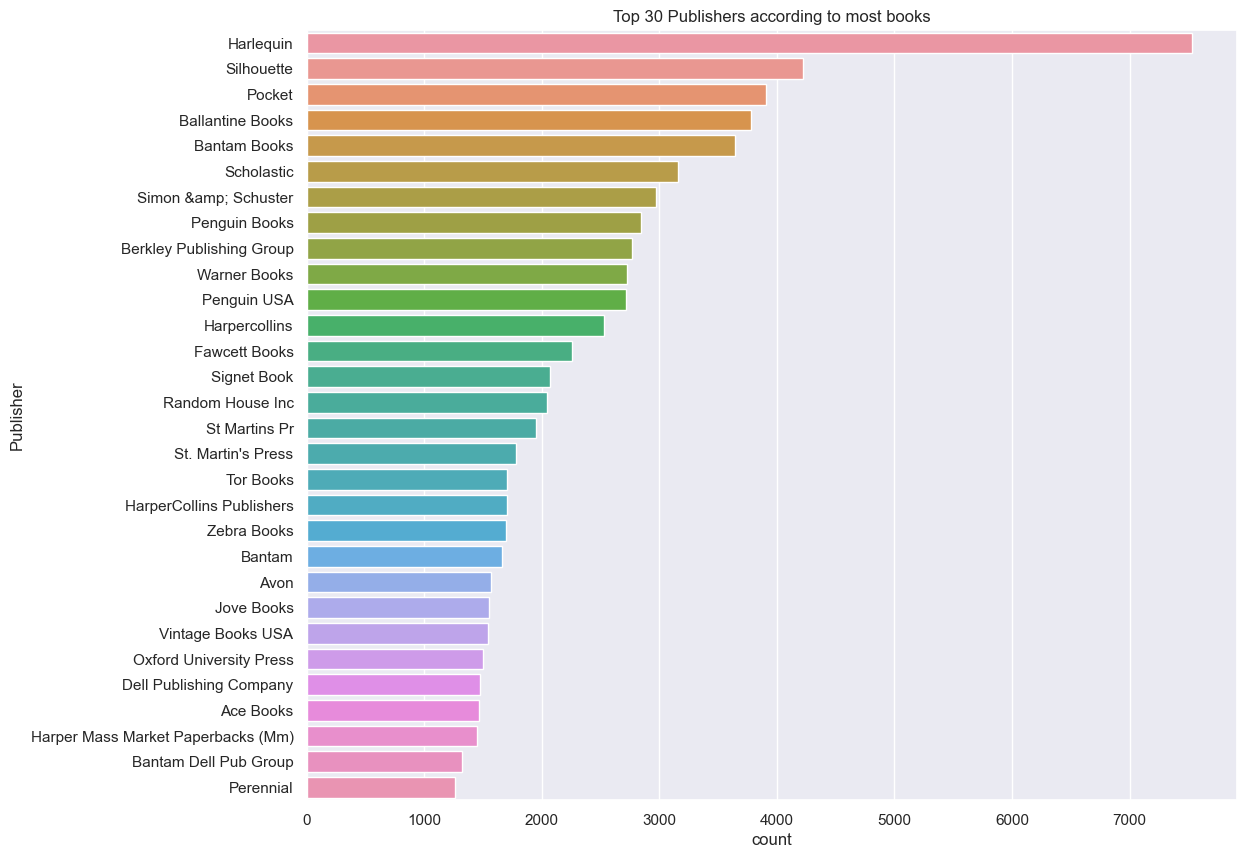

In [75]:
# Count the Number of Books for Each Publisher
top_publisher = books['publisher'].value_counts().reset_index()

# Rename Columns
top_publisher.columns = ['Publisher', 'count']
top_publisher['Publisher'] = top_publisher['Publisher']
top_publisher = top_publisher.sort_values('count',ascending=False)

# Plotting the Bar Plot
plt.figure(figsize=(12,10))
plt.title('Top 30 Publishers according to most books')
sns.barplot(data = top_publisher.head(30), x = 'count', y = 'Publisher');

The chart provides information on which publishers have the highest counts of books in the dataset. It gives a sense of the distribution of publishing activity, highlighting those publishers who have published the most books.

### Visualising the age distribution of the users

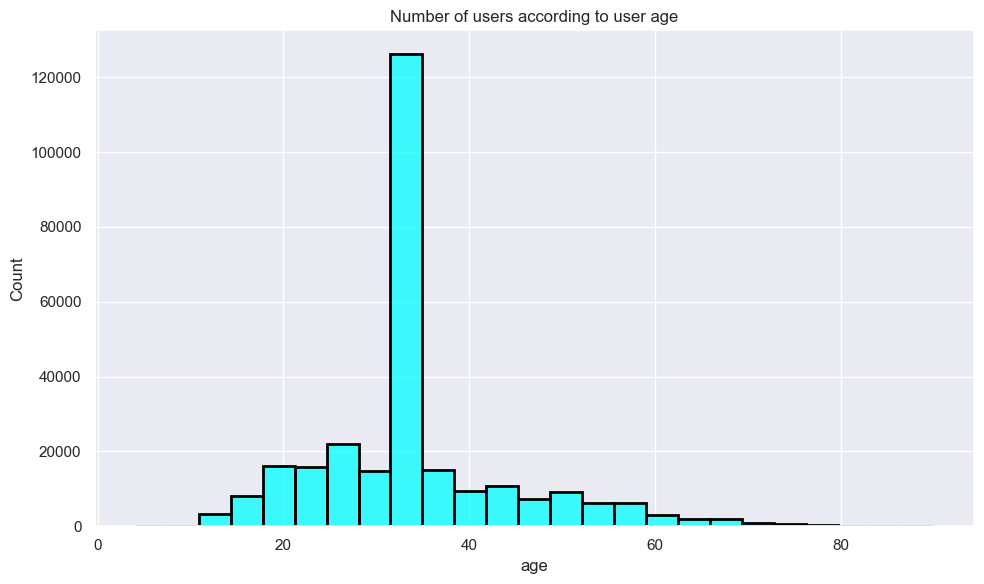

In [76]:
# Extract User Ages
user_age = users.age

# Plotting the Histogram
plt.figure(figsize=(10,6), tight_layout=True)
plt.title('Number of users according to user age')
sns.histplot(user_age, bins=25, linewidth = 2, color = 'cyan', edgecolor = 'black');

The chart provides information about the distribution of user ages, showing the frequency of users in different age intervals. It helps identify the most common age groups in the dataset and provides an overview of the age diversity among users.

Age-Group
26-35     543720
36-45     190485
46-55     126773
19-25      80009
56-65      55408
0-18       20872
66-75      12230
76-85       1573
86-100        66
Name: count, dtype: int64


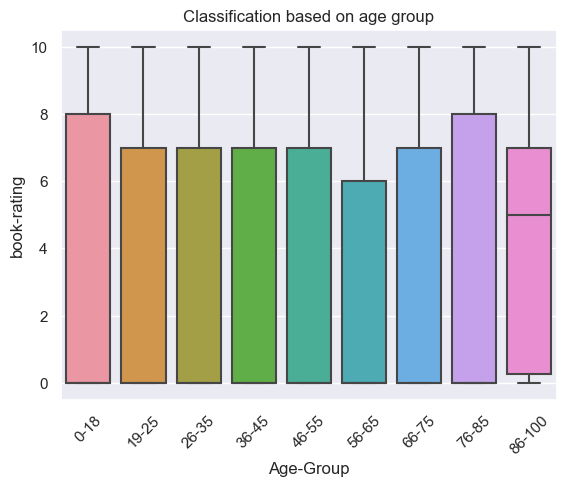

In [77]:
# Defing 
bins = [0, 18, 25, 35, 45, 55, 65, 75, 85, 100]
labels = ['0-18', '19-25', '26-35', '36-45', '46-55', '56-65', '66-75', '76-85', '86-100']

#  'Age-Group'
merged_data['Age-Group'] = pd.cut(merged_data['age'], bins=bins, labels=labels, right=False)


print(merged_data['Age-Group'].value_counts())

# Visualización de calificaciones por grupo de edad
sns.boxplot(x='Age-Group', y='bookRating', data=merged_data)
plt.title('Classification based on age group')
plt.xlabel('Age-Group')
plt.ylabel('book-rating')
plt.xticks(rotation=45)
plt.show()

Text(0.5, 1.0, 'No of readers from each country (Top 10)')

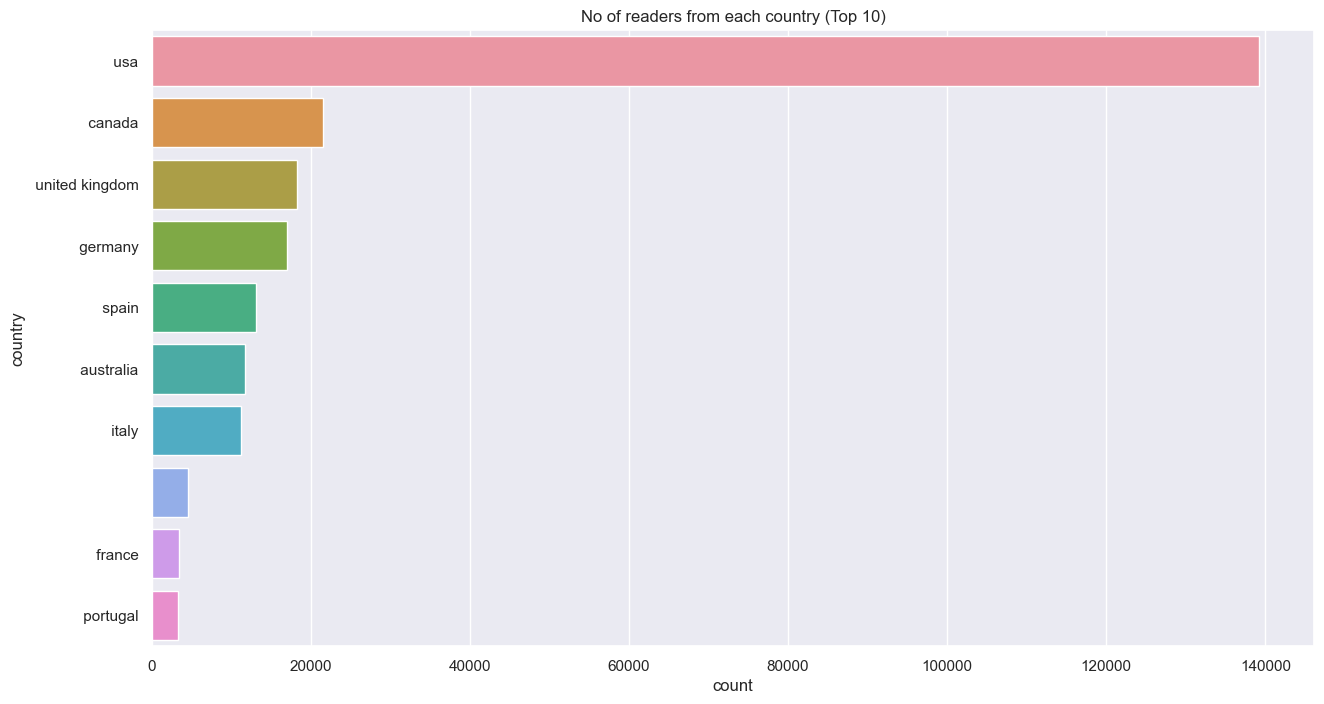

In [78]:
plt.figure(figsize=(15,8))
sns.countplot(y="country", data=users, order=users['country'].value_counts().index[0:10])
plt.title("No of readers from each country (Top 10)")

Text(0.5, 1.0, 'No of readers from states of USA (Top 15)')

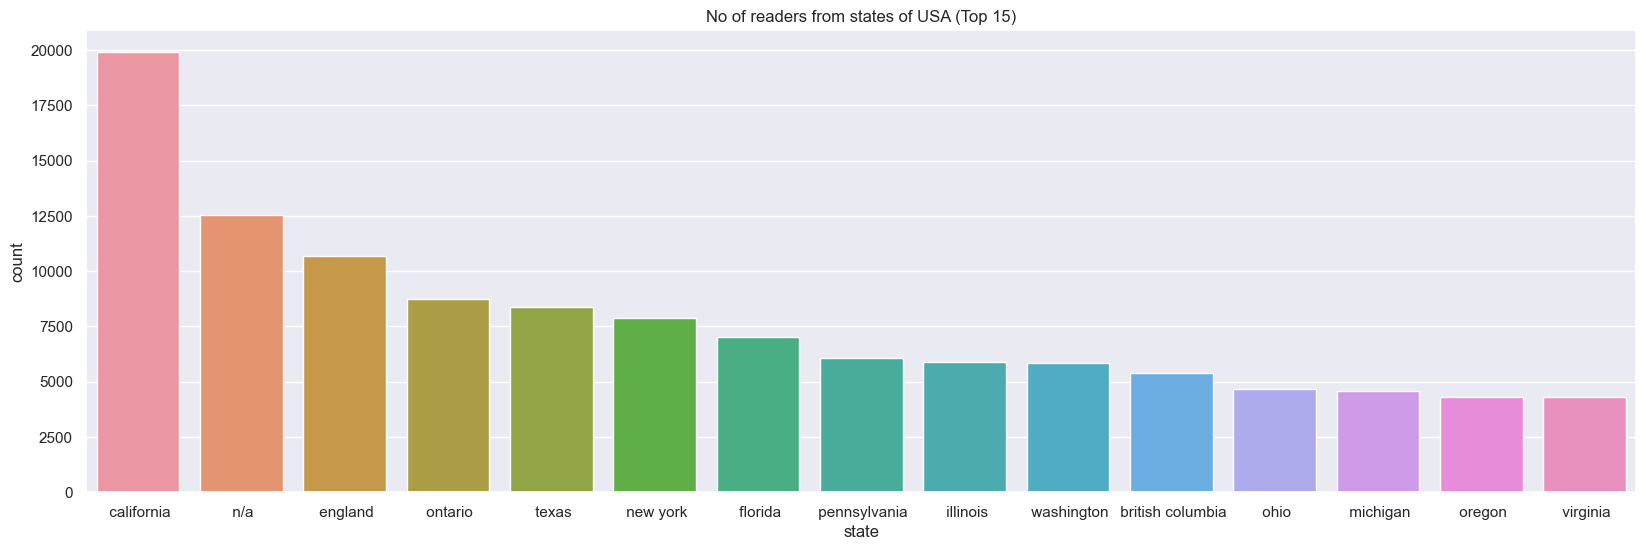

In [79]:
data=users[users['country']=='usa']
plt.figure(figsize=(20,6))
sns.countplot(x="state", data=users,order=users['state'].value_counts().index[0:15])
plt.title("No of readers from states of USA (Top 15)")

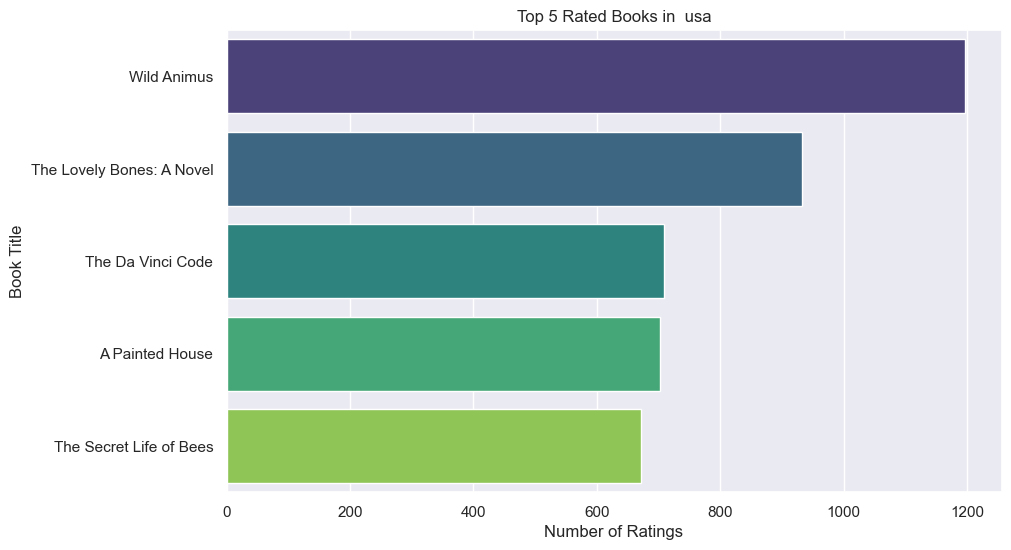

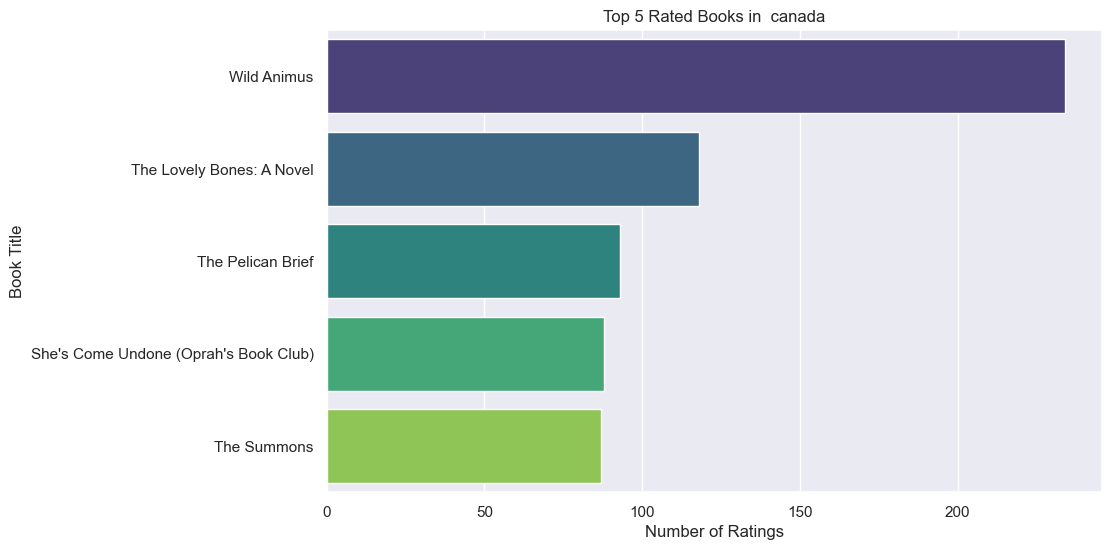

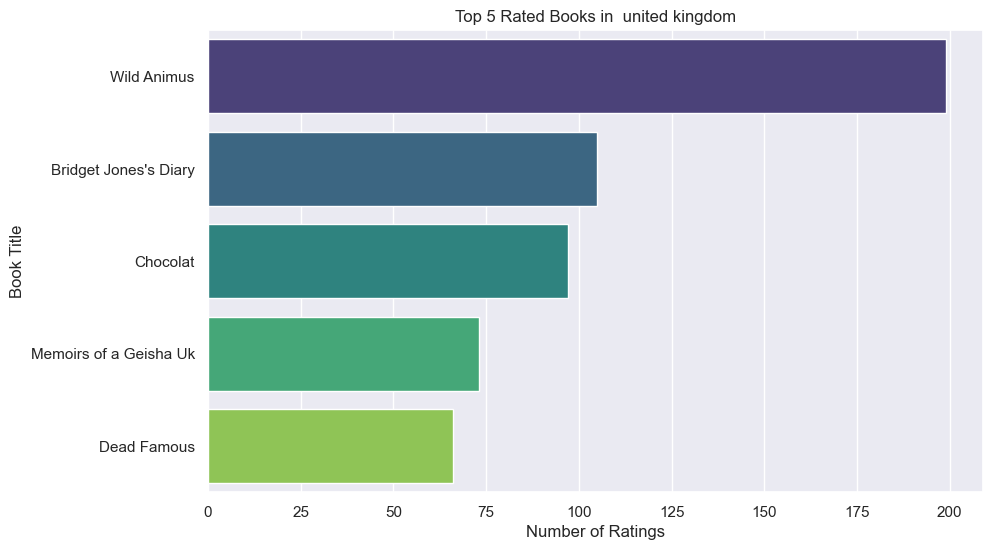

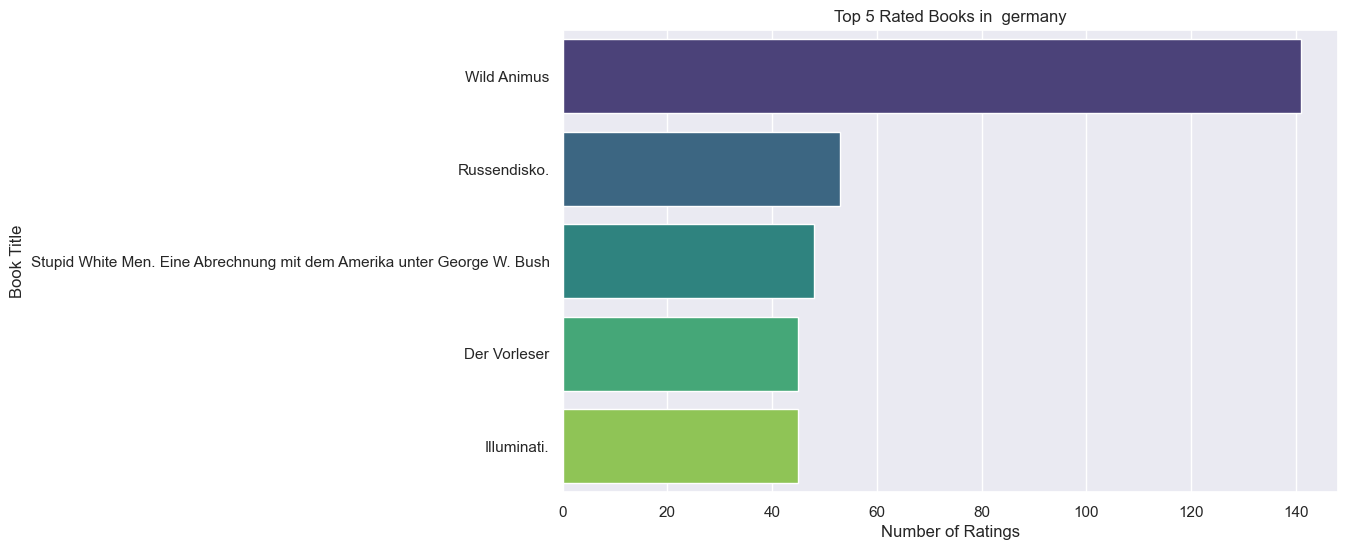

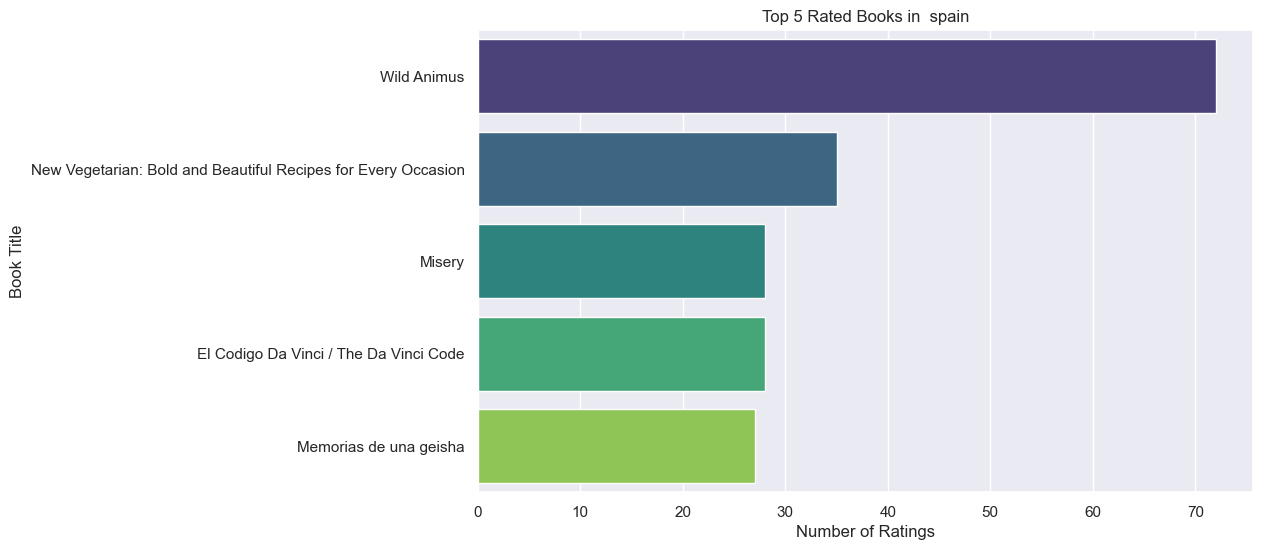

In [80]:

# Group by country and bookTitle and calculate the count of ratings
country_books = merged_data.groupby(['country', 'bookTitle'])['userId'].count().reset_index()

# Get the top 5 countries
top_countries = users['country'].value_counts().head(5).index.tolist()

# Plot top 5 books for each country
for country in top_countries:
    top_books_country = country_books[country_books['country'] == country]
    top_books_country = top_books_country.sort_values('userId', ascending=False).head(5)
    
    # Plotting the bar graph for each country
    plt.figure(figsize=(10, 6))
    sns.barplot(x='userId', y='bookTitle', data=top_books_country, palette='viridis')
    plt.xlabel('Number of Ratings')
    plt.ylabel('Book Title')
    plt.title(f'Top 5 Rated Books in {country}')
    plt.show()


In [81]:
merged_data

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,userId,bookRating,age,city,state,country,Age-Group
307558,0000913154,The Way Things Work: An Illustrated Encycloped...,C. van Amerongen (translator),1967,Simon &amp; Schuster,171118,8,47,toronto,ontario,canada,46-55
454163,0001010565,Mog's Christmas,Judith Kerr,1992,Collins,209516,0,57,felixstowe,suffolk,united kingdom,56-65
256671,0001010565,Mog's Christmas,Judith Kerr,1992,Collins,86123,0,32,peterborough,ontario,canada,26-35
210337,0001046438,Liar,Stephen Fry,1994,Harpercollins Uk,23902,9,32,london,england,united kingdom,26-35
827421,0001046713,Twopence to Cross the Mersey,Helen Forrester,1992,HarperCollins Publishers,196149,0,29,lisburn,northern ireland,united kingdom,26-35
...,...,...,...,...,...,...,...,...,...,...,...,...
378083,B000234N76,Falling Angels,Tracy Chevalier,2001,E P Dutton,264317,0,25,portela de sacavém,loures,portugal,26-35
443185,B000234NC6,It Must've Been Something I Ate: The Return of...,Jeffrey Steingarten,2002,Knopf,100906,0,34,seattle,washington,usa,26-35
632614,B00029DGGO,"Good Wife Strikes Back, The",Elizabeth Buchan,1994,Viking Adult,100088,0,26,burnley,england,united kingdom,26-35
311862,B0002JV9PY,The Blockade Runners,Jules Verne,1994,Digireads.com,179791,0,22,sydney,new south wales,australia,19-25


###### Pouplarity based Recommendation system

In [82]:

# Count the number of interactions for each book and order by popularity
book_popularity =merged_data['bookTitle'].value_counts().reset_index()
book_popularity.columns = ['bookTitle', 'popularity']

# Recommend the top 5 popular books
top_books = book_popularity.head(5)

# Display the top recommended books
print("Top 5 Recommended Books:")
print(top_books)

# Function to get top N recommendations for a specific user
def recommend_books_for_user(user_id, top_n=5):
    user_books = merged_data[merged_data['userId'] == user_id]
    user_top_books = user_books.groupby('bookTitle').size().reset_index(name='user_interactions')
    
    # Merge user's books with overall book popularity
    user_top_books = pd.merge(user_top_books, book_popularity, on='bookTitle', how='left')
    
    # Filter out books the user has already interacted with
    user_top_books = user_top_books[user_top_books['user_interactions'] == 1]
    
    # Sort by overall popularity and select the top N
    user_top_books = user_top_books.sort_values(by='popularity', ascending=False).head(top_n)
    
    return user_top_books[['bookTitle', 'popularity']]


Top 5 Recommended Books:
                    bookTitle  popularity
0                 Wild Animus        2502
1   The Lovely Bones: A Novel        1295
2           The Da Vinci Code         898
3             A Painted House         838
4  The Nanny Diaries: A Novel         828


In [83]:
recommend_books_for_user(81977, top_n=5)

,bookTitle,popularity
237,The Lovely Bones: A Novel,1295
203,The Da Vinci Code,898
243,The Nanny Diaries: A Novel,828
256,The Red Tent (Bestselling Backlist),723
24,Angels &amp; Demons,670


## Collaborative Filtering Based Recommender Sysytem

In [84]:
x=merged_data.groupby("userId").count()["bookRating"]>200
educated_users=x[x].index   # Boolean Indexing

In [85]:
filtered_rating=merged_data[merged_data["userId"].isin(educated_users)]

In [86]:
filtered_rating

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,userId,bookRating,age,city,state,country,Age-Group
307558,0000913154,The Way Things Work: An Illustrated Encycloped...,C. van Amerongen (translator),1967,Simon &amp; Schuster,171118,8,47,toronto,ontario,canada,46-55
454163,0001010565,Mog's Christmas,Judith Kerr,1992,Collins,209516,0,57,felixstowe,suffolk,united kingdom,56-65
210337,0001046438,Liar,Stephen Fry,1994,Harpercollins Uk,23902,9,32,london,england,united kingdom,26-35
210379,000104687X,"T.S. Eliot Reading \The Wasteland\"" and Other ...",T.S. Eliot,1993,HarperCollins Publishers,23902,6,32,london,england,united kingdom,26-35
210090,0001047213,The Fighting Man,Gerald Seymour,1993,HarperCollins Publishers,23902,9,32,london,england,united kingdom,26-35
...,...,...,...,...,...,...,...,...,...,...,...,...
639951,B0001I1KOG,New York Public Library Literature Companion,New York Public Library,2001,Free Press,148258,10,32,toronto,ontario,canada,26-35
462369,B0001PIOX4,Fahrenheit 451,Ray Bradbury,1993,Simon &amp; Schuster,271705,0,25,atlanta,georgia,usa,26-35
443188,B000234N3A,Fraud,David Rakoff,2001,Doubleday,100906,9,34,seattle,washington,usa,26-35
378083,B000234N76,Falling Angels,Tracy Chevalier,2001,E P Dutton,264317,0,25,portela de sacavém,loures,portugal,26-35


In [87]:
y = filtered_rating.groupby("bookTitle").count()["bookRating"]>=50
famous_books = y[y].index

In [88]:
final_ratings = filtered_rating[filtered_rating["bookTitle"].isin(famous_books)]

In [89]:
final_ratings.to_csv('final_ratings.csv', index=False)

In [90]:
final_ratings

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,userId,bookRating,age,city,state,country,Age-Group
209812,0001047973,Brave New World,Aldous Huxley,1999,Trafalgar Square Publishing,23902,9,32,london,england,united kingdom,26-35
271727,0006177379,Secrets,Vera Cowie,1990,HarperCollins Publishers,110029,0,27,norwich,england,united kingdom,26-35
694253,0020697406,The Lost World,Randall Jarrell,1985,Simon &amp; Schuster,149907,0,42,hendersonville,north carolina,usa,36-45
192254,002542730X,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc,126604,0,27,north reading,massachusetts,usa,26-35
623243,002542730X,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc,119575,0,30,north vancouver,british columbia,canada,26-35
...,...,...,...,...,...,...,...,...,...,...,...,...
383764,B00009NDAN,Winter Solstice,Rosamunde Pilcher,2000,St. Martin's Press,274301,10,41,frankston,victoria,australia,36-45
80555,B0000T6KHI,Three Fates,Nora Roberts,2002,Putnam Pub Group,112001,10,43,barren springs,virginia,usa,36-45
504280,B0000T6KHI,Three Fates,Nora Roberts,2002,Putnam Pub Group,69697,0,24,west sacramento,california,usa,19-25
462369,B0001PIOX4,Fahrenheit 451,Ray Bradbury,1993,Simon &amp; Schuster,271705,0,25,atlanta,georgia,usa,26-35


In [91]:
pt=final_ratings.pivot_table(index="bookTitle",columns="userId",values="bookRating")

In [92]:
pt.fillna(0,inplace=True)

In [93]:
pt

userId,254,2276,2766,2977,3363,4017,4385,6251,6323,6543,...,271705,273979,274004,274061,274301,274308,275970,277427,277639,278418
bookTitle,,,,,,,,,,,,,,,,,,,,,
1984,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2nd Chance,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4 Blondes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A Bend in the Road,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Year of Wonders,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
You Belong To Me,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Zen and the Art of Motorcycle Maintenance: An Inquiry into Values,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [94]:
from sklearn.metrics.pairwise import cosine_similarity

In [95]:
similarity_scores= cosine_similarity(pt)

In [96]:
similarity_scores.shape

(706, 706)

In [97]:
# Assuming you have a DataFrame named final_ratings
pt = final_ratings.pivot_table(index="bookTitle", columns="userId", values="bookRating")

# Take user ID or book title as input
user_id_or_book_title = input("Enter User ID or Book Title: ")

try:
    # Try converting the input to an integer (assuming it's a user ID)
    user_id_or_book_title = int(user_id_or_book_title)

    # Check if the user ID is valid
    if user_id_or_book_title in pt.columns:
        # Get the user's ratings for all books
        user_ratings = pt[user_id_or_book_title].dropna()

        # Sort books based on the user's ratings
        top_rated_books = user_ratings.sort_values(ascending=False).head(5)

        print(f"Top 5 rated books for User {user_id_or_book_title}:")
        for book_title, rating in top_rated_books.items():
            print(f"{book_title}: {rating}")
    else:
        print("Invalid User ID. Please enter a valid User ID.")
except ValueError:
    # If conversion to int fails, treat the input as a book title
    # Check if the book title is in the DataFrame
    if user_id_or_book_title in pt.index:
        # Get the ratings for the specified book
        ratings_for_book = pt.loc[user_id_or_book_title].dropna()

        print(f"Ratings for book '{user_id_or_book_title}':")
        for user_id, rating in ratings_for_book.items():
            print(f"User {user_id}: {rating}")
    else:
        print(f"Book '{user_id_or_book_title}' not found in the dataset.")

Enter User ID or Book Title: 254
Top 5 rated books for User 254:
American Gods: 10.0
1984: 9.0
The Secret Life of Bees: 9.0
The Bonesetter's Daughter: 9.0
Harry Potter and the Sorcerer's Stone (Book 1): 9.0


In [98]:
def recommend(book_name):
    # index fetch
    index=np.where(pt.index==book_name)[0][0]
    similar_items = sorted(list(enumerate(similarity_scores[index])),key=lambda x:x[1],reverse=True)[1:6]
    
    for i in similar_items:
        print(pt.index[i[0]])
      

In [99]:
recommend("American Gods")

The Golden Compass (His Dark Materials, Book 1)
The Eyre Affair: A Novel
Seabiscuit: An American Legend
The Amber Spyglass (His Dark Materials, Book 3)
Coraline


In [100]:
# Assuming you have a DataFrame named final_ratings
pt = final_ratings.pivot_table(index="bookTitle", columns="userId", values="bookRating")

# Take user ID and book title as input
user_id_to_check = input("Enter User ID: ")
book_title_to_check = input("Enter Book Title: ")

# Convert the input to integers (assuming user IDs are integers)
user_id_to_check = int(user_id_to_check)

# Check if the user ID is valid
if user_id_to_check in pt.columns:
    # Check if the book title is in the DataFrame
    if book_title_to_check in pt.index:
        # Get the rating given by the user for the specified book
        rating = pt.loc[book_title_to_check, user_id_to_check]

        if pd.notna(rating):
            print(f"Rating given by User {user_id_to_check} for '{book_title_to_check}': {rating}")
        else:
            print(f"User {user_id_to_check} has not rated '{book_title_to_check}'.")
    else:
        print(f"Book '{book_title_to_check}' not found in the dataset.")
else:
    print("Invalid User ID. Please enter a valid User ID.")

Enter User ID: 254
Enter Book Title: The Eyre Affair
Book 'The Eyre Affair' not found in the dataset.
